In [1]:
import numpy as np
import pandas as pd

## Скачиваем смотрим соединяем

In [2]:
X_train_val = pd.read_csv('train_features.csv', header=0)
y_train_val = pd.read_csv('train_targets.csv', header=0)
X_test = pd.read_csv('test_features.csv', header=0)
y_test = pd.read_csv('sample_submission.csv')
X_train_val.shape, y_train_val.shape, X_test.shape, y_test.shape

((5808, 11), (5808, 5), (3984, 11), (3984, 5))

In [3]:
for data in [X_train_val, X_test, y_train_val, y_test]:
    data.timestamp = pd.to_datetime(data.timestamp, format='%Y-%m-%d %H:%M:%S')

In [4]:
t_train_start, t_train_end, t_test_start, t_test_end = X_train_val.timestamp.min(), X_train_val.timestamp.max(), \
                                                       X_test.timestamp.min(), X_test.timestamp.max()
t_train_start, t_train_end, t_test_start, t_test_end

(Timestamp('2020-01-01 00:00:00'),
 Timestamp('2020-04-30 23:30:00'),
 Timestamp('2020-05-01 00:00:00'),
 Timestamp('2020-07-22 23:30:00'))

In [5]:
Xy_train_val = pd.merge(X_train_val, y_train_val, on='timestamp')
Xy_train_val.set_index('timestamp', inplace=True)

In [6]:
Xy_test = pd.merge(X_test, y_test, on='timestamp')
Xy_test.set_index('timestamp', inplace=True)

In [7]:
Xy_train_val.shape, Xy_test.shape

((5808, 14), (3984, 14))

## Графики

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
def draw_corr_with_lags(a, b, start=1, stop=220, step=1):
    data = Xy_train_val.loc[:, [a, b]]
    for i in range(start, stop, step):
        data[f'{a}_{i}'] = data[a].shift(i)
    
    data.drop(columns=a, inplace=True)
    
    plt.figure(figsize=(20, 2))
    sns.heatmap(data.corr(method='pearson').iloc[:1, 1:], annot=True, annot_kws={'size': 11}, linewidths=1)
    # sns.heatmap(data.corr(method='spearman').iloc[:1, 1:], annot=True, annot_kws={'size': 11}, linewidths=1)

### Убираем выбросы

In [10]:
Xy_train_val = Xy_train_val.mask(Xy_train_val.sub(Xy_train_val.mean()).div(Xy_train_val.std()).abs().gt(2))

### A_C2H6

In [11]:
# fig, ax = plt.subplots(1, 1, figsize=(16, 5))

# sns.lineplot(data=Xy_train_val[Xy_train_val.index.month == 3].shift(192), x='timestamp', y='A_C2H6', label='A')
# sns.lineplot(data=Xy_train_val[Xy_train_val.index.month == 3], x='timestamp', y='B_C2H6', label='B')

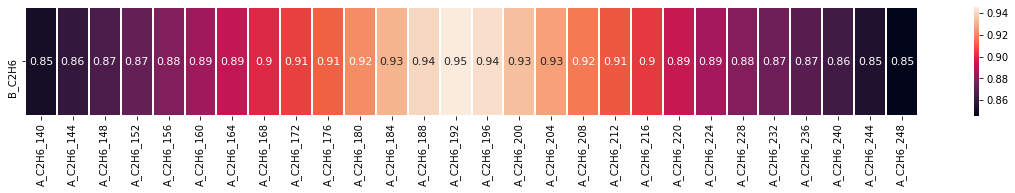

In [37]:
draw_corr_with_lags('A_C2H6', 'B_C2H6', 140, 250, 4)

### A_C3H8

In [38]:
# fig, ax = plt.subplots(1, 1, figsize=(16, 5))

# sns.lineplot(data=Xy_train_val.shift(192), x='timestamp', y='A_C3H8', label='A')
# sns.lineplot(data=Xy_train_val, x='timestamp', y='B_C3H8', label='B')

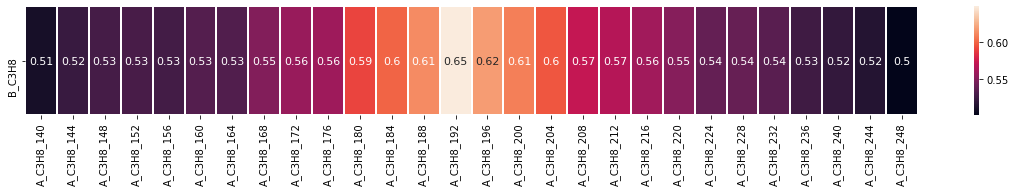

In [39]:
draw_corr_with_lags('A_C3H8', 'B_C3H8', 140, 250, 4)

### A_iC4H10

In [40]:
# fig, ax = plt.subplots(1, 1, figsize=(16, 5))

# sns.lineplot(data=Xy_train_val.shift(192), x='timestamp', y='A_iC4H10', label='A')
# sns.lineplot(data=Xy_train_val, x='timestamp', y='B_iC4H10', label='B')

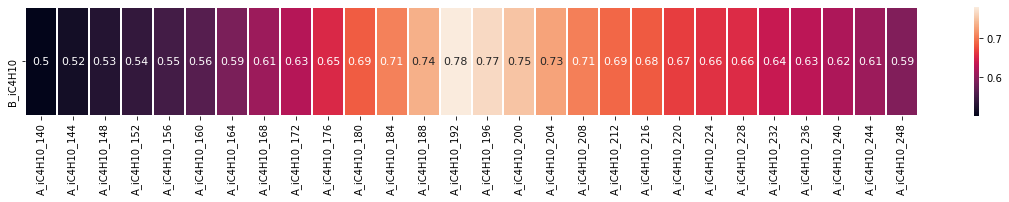

In [41]:
draw_corr_with_lags('A_iC4H10', 'B_iC4H10', 140, 250, 4)

### A_nC4H10

In [42]:
# fig, ax = plt.subplots(1, 1, figsize=(16, 5))

# sns.lineplot(data=Xy_train_val.shift(192), x='timestamp', y='A_nC4H10', label='A')
# sns.lineplot(data=Xy_train_val, x='timestamp', y='B_nC4H10', label='B')

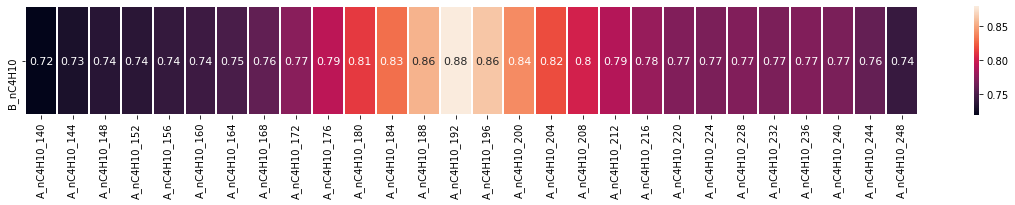

In [44]:
draw_corr_with_lags('A_nC4H10', 'B_nC4H10', 140, 250, 4)

In [33]:
Xy_train_val['A_C2H6'].fillna(Xy_train_val['B_C2H6'].shift(-192), inplace=True)
Xy_train_val['A_C3H8'].fillna(Xy_train_val['B_C3H8'].shift(-192), inplace=True)
Xy_train_val['A_iC4H10'].fillna(Xy_train_val['B_iC4H10'].shift(-192), inplace=True)
Xy_train_val['A_nC4H10'].fillna(Xy_train_val['B_nC4H10'].shift(-192), inplace=True)

In [45]:
Xy = pd.concat([Xy_train_val, Xy_test], axis=0)

for name in ['A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10']:
    for i in range(176, 208, 1):
        Xy.loc[:, f'{name}_{i}'] = Xy.loc[:, name].shift(i)

for name in ['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10', 
             'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate']:
    Xy.loc[:, f'{name}_1'] = Xy.loc[:, name].shift(1)
    Xy.loc[:, f'{name}_diff'] = Xy.loc[:, name].diff(1)

Xy = Xy.iloc[200:]

Xy['day_of_month'] = Xy.index.day.to_numpy()

Xy.shape, len(Xy.columns), Xy.columns

((9592, 163),
 163,
 Index(['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
        'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate',
        ...
        'A_nC4H10_diff', 'A_iC5H12_1', 'A_iC5H12_diff', 'A_nC5H12_1',
        'A_nC5H12_diff', 'A_C6H14_1', 'A_C6H14_diff', 'B_rate_1', 'B_rate_diff',
        'day_of_month'],
       dtype='object', length=163))

In [46]:
Xy_exp_train_val, Xy_exp_test = Xy.loc[t_train_start:t_train_end], Xy.loc[t_test_start:t_test_end]
Xy_exp_train_val.shape, Xy_exp_test.shape

((5608, 163), (3984, 163))

In [47]:
values_for_filling_na = Xy_exp_train_val.mean(axis=0).values
for i, col in enumerate(Xy_exp_train_val.columns):
    Xy_exp_train_val[col].fillna(values_for_filling_na[i], inplace=True)
    Xy_exp_test[col].fillna(values_for_filling_na[i], inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [48]:
Xy_exp_train_val.shape, Xy_exp_test.shape

((5608, 163), (3984, 163))

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(Xy_exp_train_val.drop(columns=['B_C2H6', 'B_C3H8', 
                                                                                     'B_iC4H10', 'B_nC4H10']), 
                                                      Xy_exp_train_val.loc[:, ['B_C2H6', 'B_C3H8', 
                                                                               'B_iC4H10', 'B_nC4H10']], 
                                                      test_size=0.3, shuffle=False)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((3925, 159), (1683, 159), (3925, 4), (1683, 4))

In [50]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso

In [51]:
mape = lambda y_true, y_pred: np.mean(((y_true - y_pred) / y_true).abs().mean().values) * 100

In [52]:
X = Xy_exp_train_val.drop(columns=['B_C2H6', 'B_C3H8', 'B_iC4H10', 'B_nC4H10'])
y = Xy_exp_train_val.loc[:, ['B_C2H6', 'B_C3H8', 'B_iC4H10', 'B_nC4H10']]

In [53]:
from hyperopt import hp, fmin, tpe

In [58]:
def return_best_cb_model(X_tr, y_tr, X_test, y_test, X, y, num_of_evals = 10):
    
    def hyperopt_opt_score(params):
        reg = CatBoostRegressor(allow_writing_files=False, verbose=False, **params, random_seed=42, objective='MAPE',
                                cat_features=['day_of_month']).fit(X_tr, y_tr)
        
        y_pred = reg.predict(X_test)
        
        return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
    cb_space = {
        'eta': hp.uniform('eta', 0.01, 0.20),
        'n_estimators': hp.choice('n_estimators', np.arange(200, 1000, 100)),
        'depth': hp.choice('depth', np.arange(3, 8, 1)),
        'subsample': hp.uniform('subsample', 0.5, 1.0),
        'rsm': hp.uniform('rsm', 0.5, 1.0),
        'l2_leaf_reg': hp.choice('l2_leaf_reg', np.arange(3, 10, 2))
    }
    
    best_params = fmin(fn = hyperopt_opt_score, space = cb_space, algo = tpe.suggest, max_evals = num_of_evals)
    
    best_params['n_estimators'] = np.arange(200, 1000, 100)[best_params['n_estimators']]
    best_params['l2_leaf_reg'] = np.arange(3, 10, 2)[best_params['l2_leaf_reg']]
    best_params['depth'] = np.arange(3, 8, 1)[best_params['depth']]
    
    print(best_params)
    
    reg = CatBoostRegressor(allow_writing_files=False, verbose=200, **best_params, random_seed=42, objective='MAPE',
                            cat_features=['day_of_month']).fit(X, y)
    return reg

In [ ]:
def return_best_lgbm_model(X_tr, y_tr, X_test, y_test, X, y, num_of_evals = 10):
    
    def hyperopt_opt_score(params):
        reg = LGBMRegressor(verbose=False, **params, random_seed=42, objective='mape').fit(X_tr, y_tr)
        
        y_pred = reg.predict(X_test)
        
        return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
    cb_space = {
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.20),
        'num_iterations': hp.choice('num_iterations', np.arange(200, 1000, 100)),
        'max_depth': hp.choice('max_depth', np.arange(4, 11, 1)),
        'num_leaves': hp.choice('num_leaves', np.arange(20, 140, 4)),
        'rsm': hp.uniform('rsm', 0.5, 1.0),
        'l2_leaf_reg': hp.choice('l2_leaf_reg', np.arange(3, 10, 2))
    }
    
    best_params = fmin(fn = hyperopt_opt_score, space = cb_space, algo = tpe.suggest, max_evals = num_of_evals)
    
    best_params['n_estimators'] = np.arange(200, 1000, 100)[best_params['n_estimators']]
    best_params['l2_leaf_reg'] = np.arange(3, 10, 2)[best_params['l2_leaf_reg']]
    best_params['max_depth'] = np.arange(3, 8, 1)[best_params['max_depth']]
    
    print(best_params)
    
    reg = CatBoostRegressor(allow_writing_files=False, verbose=200, **best_params, random_seed=42, objective='MAPE',
                            cat_features=['day_of_month']).fit(X, y)
    return reg

In [59]:
models = {}
for col in y.columns:
    models[col] = return_best_cb_model(X_train, y_train[col], X_valid, y_valid[col], X, y[col], num_of_evals = 100)

100%|██████████| 100/100 [17:20<00:00, 10.41s/trial, best loss: 7.979763107671606]
{'depth': 3, 'eta': 0.01590226327983149, 'l2_leaf_reg': 5, 'n_estimators': 600, 'rsm': 0.9475345530699254, 'subsample': 0.8675940302902865}
0:	learn: 0.1908802	total: 10.3ms	remaining: 6.14s
200:	learn: 0.0432437	total: 1.9s	remaining: 3.77s
400:	learn: 0.0364418	total: 3.66s	remaining: 1.82s
599:	learn: 0.0347107	total: 5.4s	remaining: 0us
100%|██████████| 100/100 [17:32<00:00, 10.53s/trial, best loss: 2.1154336077914535]
{'depth': 3, 'eta': 0.02449435024749859, 'l2_leaf_reg': 7, 'n_estimators': 200, 'rsm': 0.7580872733339655, 'subsample': 0.7159961675690216}
0:	learn: 0.0286030	total: 7.53ms	remaining: 1.5s
199:	learn: 0.0163002	total: 1.47s	remaining: 0us
100%|██████████| 100/100 [15:20<00:00,  9.20s/trial, best loss: 1.514389218126773]
{'depth': 3, 'eta': 0.011618239504716698, 'l2_leaf_reg': 7, 'n_estimators': 200, 'rsm': 0.7111601470545491, 'subsample': 0.6818904995788772}
0:	learn: 0.0262211	total:

In [ ]:
models = {}
for col in y.columns:
    models[col] = return_best_model(X_train, y_train[col], X_valid, y_valid[col], X, y[col], num_of_evals=50)

In [60]:
X_test = Xy_exp_test.drop(columns=['B_C2H6', 'B_C3H8', 'B_iC4H10', 'B_nC4H10'])
y_pred = Xy_exp_test.loc[:, ['B_C2H6', 'B_C3H8', 'B_iC4H10', 'B_nC4H10']].copy()
for col in y_pred.columns:
    y_pred[col] = models[col].predict(X_test)

In [61]:
y_pred.to_csv('submission_9_TS_morelags.csv')